# QBUS2820 Assignment 2

**SID:** 510575452

In [19]:
# Importing Relevant Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

# Loading in Dataset

In [77]:
# Step 1: Load the data, parse the "Quarter" column as dates
CPI_train_data = pd.read_csv('data/CPI_train.csv', index_col='Quarter')

# Parse dates with the format 'Mar-97'
CPI_train_data.index = pd.to_datetime(CPI_train_data.index, format='%b-%y', errors='coerce')

# Convert to quarterly periods
CPI_train_data.index = CPI_train_data.index.to_period('Q')

CPI_train_data

,CPI
Quarter,
1997Q1,94.5
1997Q2,93.1
1997Q3,95.4
1997Q4,96.3
1998Q1,96.0
...,...
2020Q4,125.3
2021Q1,123.6
2021Q2,124.5


# EDA

## Looking at Key Characteristics of the dataset

In [78]:
CPI_train_data.head()

,CPI
Quarter,
1997Q1,94.5
1997Q2,93.1
1997Q3,95.4
1997Q4,96.3
1998Q1,96.0


In [86]:
CPI_train_data.tail()

,CPI
Quarter,
2020Q4,125.3
2021Q1,123.6
2021Q2,124.5
2021Q3,126.2
2021Q4,125.8


In [79]:
CPI_train_data.columns

Index(['CPI'], dtype='object')

In [80]:
CPI_train_data.shape

(100, 1)

## Data Cleaning

### Removing null values

In [81]:
clean_CPI_train_data = CPI_train_data.dropna()

## Looking at the information of the dataset

In [82]:
clean_CPI_train_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 100 entries, 1997Q1 to 2021Q4
Freq: Q-DEC
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CPI     100 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB


## Looking at the description of the dataset

In [83]:
clean_CPI_train_data.describe()

,CPI
count,100.000000
mean,113.704000
std,9.187496
min,93.100000
25%,105.875000
50%,116.600000
75%,120.350000
max,126.200000


## Checking for Null Value

In [84]:
clean_CPI_train_data.isnull().sum()

CPI    0
dtype: int64

## Looking at the trend of the data

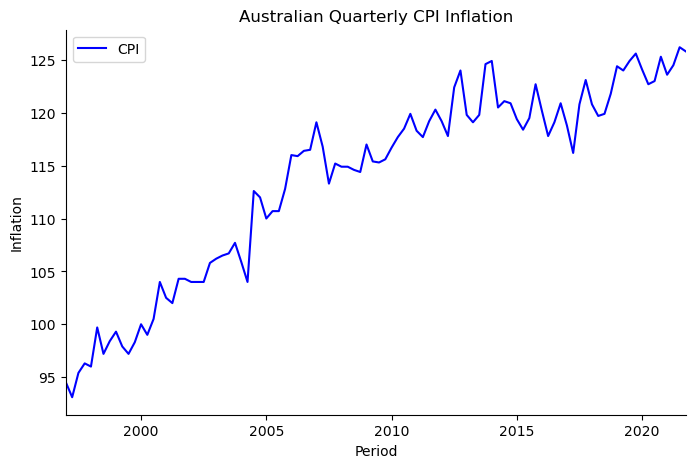

In [93]:
fig, ax = plt.subplots(figsize=(8, 5))
clean_CPI_train_data.plot(color='b', ax=ax)   
ax.set_xlabel('Period')
ax.set_ylabel('Inflation')
ax.set_title('Australian Quarterly CPI Inflation')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()